# Projeto Final - MC886
### Titulo: Como a mobilidade urbana se relaciona com o aumento de numero de casos de covid.

In [1]:
# imports
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense


# %matplotlib notebook

### Carrega dados de Mobilidade do Google

In [2]:
gmr_df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')
gmr_df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [3]:
# Categories available
categories_google_mobility = ['retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline']

regions_list_BR = [ 'Federal District', 'State of Acre','State of Alagoas','State of Amapá', 'State of Amazonas', 
                    'State of Bahia', 'State of Ceará', 'State of Espírito Santo', 'State of Goiás',
                    'State of Maranhão', 'State of Mato Grosso', 'State of Mato Grosso do Sul', 'State of Minas Gerais',
                    'State of Pará', 'State of Paraíba', 'State of Paraná', 'State of Pernambuco', 'State of Piauí', 
                    'State of Rio de Janeiro', 'State of Rio Grande do Norte',
                    'State of Rio Grande do Sul', 'State of Rondônia', 'State of Roraima', 'State of Santa Catarina', 
                    'State of São Paulo', 'State of Sergipe', 'State of Tocantins'
                  ]

regions_abbr_BR = [ 'DF','AC','AL','AP','AM','BA','CE','ES','GO','MA','MT','MS','MG','PA',
                    'PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SP','SE','TO']


In [4]:
def getAllRegionsGroups(regions_list=regions_list_BR, country="Brazil"):
    regions_dict = {}
#     print(regions_list)
    for r in regions_list:
        sub_df = gmr_df[(gmr_df['country_region']== country) & (gmr_df['sub_region_1']==r) & (pd.isnull(gmr_df['sub_region_2']))]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r]=sub_df
#     print(regions_dict)
    return regions_dict

def getCityGroups(cities_list, country="Brazil"):
    regions_dict = {}
#     print(regions_list)
    for r in cities_list:
        sub_df = gmr_df[(gmr_df['country_region']== country) & (gmr_df['sub_region_2']==r)]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r]=sub_df
#     print(regions_dict)
    return regions_dict


def plotGroups(sub_df, region, country="Brazil"):
    # let's plot all time series for this region
    for group in categories_google_mobility:
        fig, ax = plt.subplots(figsize=(16, 4))
        plt.plot(sub_df['date'], sub_df[group], label=group)
        ax.axhline(y=0, color='gray')
        ax.axvline(pd.to_datetime('2020-03-10'), color='r', linestyle='--', lw=2)
        plt.title(country + ' '+ region + ': ' + group)
        plt.legend(loc='best') 
        plt.grid()
        plt.show()
        

In [38]:
# - - - - - - - -  CASOS DE COVID - - - - - - - -  
covid_df = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
col = [ 'epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths', 'newCases', 'totalCases', 
        'deathsMS', 'totalCasesMS', 'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants', 
        'deaths_by_totalCases', 
        'recovered', 'suspects', 'tests', 'tests_per_100k_inhabitants', 'vaccinated', 
        'vaccinated_per_100_inhabitants', 'vaccinated_second', 
        'vaccinated_second_per_100_inhabitants', 'vaccinated_single', 'vaccinated_single_per_100_inhabitants']

# print(covid_df.head)

def getAllRegionsCovid(regions_list=regions_list_BR, regions_abbr=regions_abbr_BR,
                       country="Brazil"):
    regions_dict = {}
    
    for r in range(len(regions_list)):
        sub_df = covid_df[(covid_df['state']== regions_abbr[r])]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[regions_list[r]]=sub_df
    return regions_dict


    

In [39]:
def getData():
    cases_df = getAllRegionsCovid(regions_list_BR,regions_abbr_BR)
    mob_df = getAllRegionsGroups(regions_list_BR)
    
    mobility_all = []
    cases_all = []
    mobility_dates = []
    cases_dates = []
    mobility_dict = {}
    cases_dict = {}
    
    for r in regions_list_BR:
        newCases = cases_df[r]['newCases'].values
        newCases_norm = newCases/np.max(newCases)
        scaler = MinMaxScaler(feature_range=(-1,1))        
        mobility_norm = scaler.fit_transform(mob_df[r][categories_google_mobility].values)
        
        covid_dates = cases_df[r]['date'].values
        
        mob_dates = mob_df[r]['date'].values
        mob_dates += np.timedelta64(7,'D') # com offset de 7 dias
        
        mobility_dict[r] = mobility_norm
        cases_dict[r] = newCases_norm
        
        for i in range(len(newCases_norm)):
            if covid_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
                cases_all.append(newCases_norm[i]) 
                cases_dates.append(covid_dates[i])
            
        for i in range(len(mobility_norm)):
            if mob_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
                mobility_all.append(mobility_norm[i])
                mobility_dates.append(mob_dates[i])

    Y_data = (np.array([cases_all]).T)
    X_data = np.array(mobility_all)    
    
    
    return X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict


X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict = getData()

print(X_data.shape)
print(Y_data.shape)

(11259, 6)
(11151, 1)


In [40]:
# count_gp = 0

# for group in categories_google_mobility:
#     print(group)
#     group_values = X_data[:,count_gp]
#     fig, ax = plt.subplots(figsize=(8, 4))
#     plt.plot(cases_dates[:], Y_data[:], label="new_cases")
#     plt.plot(mobility_dates[:], group_values[:], label=group)
   
#     plt.legend(loc='best') 
#     plt.grid()
#     plt.show()
    
#     count_gp+=1

In [41]:
def getCorrespondentData(X_data,Y_data, mobility_dates,cases_dates):
    i = 0
    j = 0
    X_filter = []
    Y_filter = []
    while (i < len(mobility_dates)) and (j < len(cases_dates)):
#         print(mobility_dates[i]," - ", cases_dates[j])
        if mobility_dates[i] == cases_dates[j]:
            if not np.any(np.isnan(X_data[i])) and not np.isnan(Y_data[j]):
                X_filter.append(X_data[i])
                Y_filter.append(Y_data[j])
            i+=1
            j+=1
        elif cases_dates[j] > (mobility_dates[i] + np.timedelta64(20,'W')):
            j+=1
        elif (mobility_dates[i] < cases_dates[j]) or mobility_dates[i] > (cases_dates[j] + np.timedelta64(20,'W')):
            i += 1
        elif (mobility_dates[i] > cases_dates[j]):
            j += 1
             
    return np.array(X_filter), np.array(Y_filter)

In [42]:
X_filter, Y_filter = getCorrespondentData(X_data,Y_data, mobility_dates,cases_dates)
print(X_filter.shape)
print(Y_filter.shape)

# i = 0

# for group in categories_google_mobility:
#     print(group)
#     group_values = X_filter[:,i]
#     fig, ax = plt.subplots(figsize=(16, 4))
#     plt.scatter(group_values[:], Y_filter[:], label=group) #com offset de 7 dias
# #     plt.scatter(group_values[-460:], newCases_norm[-463:-3], label=group) #sem offset de 7 dias 
   
#     plt.legend(loc='best') 
#     plt.grid()
#     plt.show()
    
#     i+=1

(11028, 6)
(11028, 1)


In [43]:

X_train = X_filter[:9000]
Y_train = Y_filter[:9000]
X_test = X_filter[9000:]
Y_test = Y_filter[9000:]
# X = mobility_norm[-460:,:]
# Y = newCases_norm[-470:-10]
# Y = Y.reshape((len(Y),1))

print("Mobility Features")
print(X_train[:5])
print("X shape: ",X_train.shape)


print("Covid Cases")
print(Y_train[:5])
print("Y shape: ",Y_train.shape)



Mobility Features
[[-0.50537634 -0.16129032 -0.76397516 -0.35802469 -0.2         0.4375    ]
 [-0.50537634 -0.11290323 -0.73913043 -0.33333333 -0.2         0.375     ]
 [-0.44086022 -0.08064516 -0.68944099 -0.30864198 -0.2         0.3125    ]
 [-0.41935484 -0.03225806 -0.61490683 -0.30864198 -0.2         0.375     ]
 [-0.39784946  0.11290323 -0.71428571 -0.2345679  -0.12380952  0.5       ]]
X shape:  (9000, 6)
Covid Cases
[[0.23021129]
 [0.23525702]
 [0.24093346]
 [0.28476821]
 [0.40523494]]
Y shape:  (9000, 1)


In [44]:
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='relu'))

In [45]:


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=700, batch_size=180)



Epoch 1/700
50/50 [==============================] - 1s 753us/step - loss: 0.8589 - accuracy: 0.0129
Epoch 2/700
50/50 [==============================] - 0s 733us/step - loss: 0.5636 - accuracy: 0.0113
Epoch 3/700
50/50 [==============================] - 0s 702us/step - loss: 0.5612 - accuracy: 0.0117
Epoch 4/700
50/50 [==============================] - 0s 651us/step - loss: 0.5572 - accuracy: 0.0110
Epoch 5/700
50/50 [==============================] - 0s 692us/step - loss: 0.5536 - accuracy: 0.0108
Epoch 6/700
50/50 [==============================] - 0s 723us/step - loss: 0.5543 - accuracy: 0.0101
Epoch 7/700
50/50 [==============================] - 0s 692us/step - loss: 0.5547 - accuracy: 0.0111
Epoch 8/700
50/50 [==============================] - 0s 784us/step - loss: 0.5544 - accuracy: 0.0101
Epoch 9/700
50/50 [==============================] - 0s 855us/step - loss: 0.5454 - accuracy: 0.0111
Epoch 10/700
50/50 [==============================] - 0s 753us/step - loss: 0.5455 - accura

50/50 [==============================] - 0s 712us/step - loss: 0.5279 - accuracy: 0.0113
Epoch 82/700
50/50 [==============================] - 0s 682us/step - loss: 0.5293 - accuracy: 0.0116
Epoch 83/700
50/50 [==============================] - 0s 631us/step - loss: 0.5262 - accuracy: 0.0113
Epoch 84/700
50/50 [==============================] - 0s 672us/step - loss: 0.5283 - accuracy: 0.0107
Epoch 85/700
50/50 [==============================] - 0s 631us/step - loss: 0.5315 - accuracy: 0.0105
Epoch 86/700
50/50 [==============================] - 0s 753us/step - loss: 0.5322 - accuracy: 0.0122
Epoch 87/700
50/50 [==============================] - 0s 651us/step - loss: 0.5262 - accuracy: 0.0113
Epoch 88/700
50/50 [==============================] - 0s 651us/step - loss: 0.5281 - accuracy: 0.0109
Epoch 89/700
50/50 [==============================] - 0s 692us/step - loss: 0.5276 - accuracy: 0.0105
Epoch 90/700
50/50 [==============================] - 0s 631us/step - loss: 0.5276 - accuracy: 

50/50 [==============================] - 0s 651us/step - loss: 0.5245 - accuracy: 0.0111
Epoch 161/700
50/50 [==============================] - 0s 651us/step - loss: 0.5229 - accuracy: 0.0095
Epoch 162/700
50/50 [==============================] - 0s 712us/step - loss: 0.5231 - accuracy: 0.0107
Epoch 163/700
50/50 [==============================] - 0s 631us/step - loss: 0.5254 - accuracy: 0.0107
Epoch 164/700
50/50 [==============================] - 0s 753us/step - loss: 0.5225 - accuracy: 0.0103
Epoch 165/700
50/50 [==============================] - 0s 651us/step - loss: 0.5254 - accuracy: 0.0096
Epoch 166/700
50/50 [==============================] - 0s 733us/step - loss: 0.5227 - accuracy: 0.0110
Epoch 167/700
50/50 [==============================] - 0s 1ms/step - loss: 0.5225 - accuracy: 0.0080
Epoch 168/700
50/50 [==============================] - 0s 1ms/step - loss: 0.5242 - accuracy: 0.0131
Epoch 169/700
50/50 [==============================] - 0s 1ms/step - loss: 0.5217 - accurac

50/50 [==============================] - 0s 651us/step - loss: 0.5186 - accuracy: 0.0096
Epoch 241/700
50/50 [==============================] - 0s 651us/step - loss: 0.5217 - accuracy: 0.0104
Epoch 242/700
50/50 [==============================] - 0s 631us/step - loss: 0.5241 - accuracy: 0.0139
Epoch 243/700
50/50 [==============================] - 0s 651us/step - loss: 0.5211 - accuracy: 0.0094
Epoch 244/700
50/50 [==============================] - 0s 712us/step - loss: 0.5251 - accuracy: 0.0098
Epoch 245/700
50/50 [==============================] - 0s 875us/step - loss: 0.5197 - accuracy: 0.0097
Epoch 246/700
50/50 [==============================] - 0s 773us/step - loss: 0.5218 - accuracy: 0.0099
Epoch 247/700
50/50 [==============================] - 0s 753us/step - loss: 0.5175 - accuracy: 0.0103
Epoch 248/700
50/50 [==============================] - 0s 672us/step - loss: 0.5225 - accuracy: 0.0109
Epoch 249/700
50/50 [==============================] - 0s 651us/step - loss: 0.5244 - a

50/50 [==============================] - 0s 651us/step - loss: 0.5204 - accuracy: 0.0114
Epoch 320/700
50/50 [==============================] - 0s 773us/step - loss: 0.5228 - accuracy: 0.0115
Epoch 321/700
50/50 [==============================] - 0s 712us/step - loss: 0.5184 - accuracy: 0.0104
Epoch 322/700
50/50 [==============================] - 0s 692us/step - loss: 0.5230 - accuracy: 0.0102
Epoch 323/700
50/50 [==============================] - 0s 651us/step - loss: 0.5220 - accuracy: 0.0112
Epoch 324/700
50/50 [==============================] - 0s 773us/step - loss: 0.5164 - accuracy: 0.0114
Epoch 325/700
50/50 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.01 - 0s 631us/step - loss: 0.5157 - accuracy: 0.0123
Epoch 326/700
50/50 [==============================] - 0s 773us/step - loss: 0.5210 - accuracy: 0.0099
Epoch 327/700
50/50 [==============================] - 0s 855us/step - loss: 0.5213 - accuracy: 0.0104
Epoch 328/700
50/50 [========================

50/50 [==============================] - 0s 865us/step - loss: 0.5205 - accuracy: 0.0099
Epoch 399/700
50/50 [==============================] - 0s 733us/step - loss: 0.5241 - accuracy: 0.0088
Epoch 400/700
50/50 [==============================] - 0s 763us/step - loss: 0.5182 - accuracy: 0.0116
Epoch 401/700
50/50 [==============================] - 0s 957us/step - loss: 0.5215 - accuracy: 0.0105
Epoch 402/700
50/50 [==============================] - 0s 814us/step - loss: 0.5175 - accuracy: 0.0109
Epoch 403/700
50/50 [==============================] - 0s 794us/step - loss: 0.5188 - accuracy: 0.0112
Epoch 404/700
50/50 [==============================] - 0s 611us/step - loss: 0.5168 - accuracy: 0.0139
Epoch 405/700
50/50 [==============================] - 0s 692us/step - loss: 0.5197 - accuracy: 0.0113
Epoch 406/700
50/50 [==============================] - 0s 672us/step - loss: 0.5217 - accuracy: 0.0109
Epoch 407/700
50/50 [==============================] - 0s 692us/step - loss: 0.5190 - a

50/50 [==============================] - 0s 672us/step - loss: 0.5179 - accuracy: 0.0096
Epoch 478/700
50/50 [==============================] - 0s 753us/step - loss: 0.5180 - accuracy: 0.0117
Epoch 479/700
50/50 [==============================] - 0s 743us/step - loss: 0.5195 - accuracy: 0.0119
Epoch 480/700
50/50 [==============================] - 0s 712us/step - loss: 0.5162 - accuracy: 0.0122
Epoch 481/700
50/50 [==============================] - 0s 712us/step - loss: 0.5179 - accuracy: 0.0109
Epoch 482/700
50/50 [==============================] - 0s 651us/step - loss: 0.5189 - accuracy: 0.0114
Epoch 483/700
50/50 [==============================] - 0s 733us/step - loss: 0.5147 - accuracy: 0.0098
Epoch 484/700
50/50 [==============================] - 0s 672us/step - loss: 0.5177 - accuracy: 0.0116
Epoch 485/700
50/50 [==============================] - 0s 692us/step - loss: 0.5190 - accuracy: 0.0118
Epoch 486/700
50/50 [==============================] - 0s 631us/step - loss: 0.5236 - a

50/50 [==============================] - 0s 957us/step - loss: 0.5174 - accuracy: 0.0117
Epoch 557/700
50/50 [==============================] - 0s 1ms/step - loss: 0.5147 - accuracy: 0.0126
Epoch 558/700
50/50 [==============================] - 0s 733us/step - loss: 0.5159 - accuracy: 0.0104
Epoch 559/700
50/50 [==============================] - 0s 692us/step - loss: 0.5113 - accuracy: 0.0108
Epoch 560/700
50/50 [==============================] - 0s 814us/step - loss: 0.5186 - accuracy: 0.0116
Epoch 561/700
50/50 [==============================] - 0s 733us/step - loss: 0.5145 - accuracy: 0.0120
Epoch 562/700
50/50 [==============================] - 0s 814us/step - loss: 0.5128 - accuracy: 0.0113
Epoch 563/700
50/50 [==============================] - 0s 753us/step - loss: 0.5139 - accuracy: 0.0116
Epoch 564/700
50/50 [==============================] - 0s 773us/step - loss: 0.5165 - accuracy: 0.0130
Epoch 565/700
50/50 [==============================] - 0s 733us/step - loss: 0.5194 - acc

50/50 [==============================] - 0s 672us/step - loss: 0.5190 - accuracy: 0.0114
Epoch 636/700
50/50 [==============================] - 0s 611us/step - loss: 0.5180 - accuracy: 0.0109
Epoch 637/700
50/50 [==============================] - 0s 794us/step - loss: 0.5151 - accuracy: 0.0138
Epoch 638/700
50/50 [==============================] - 0s 764us/step - loss: 0.5181 - accuracy: 0.0121
Epoch 639/700
50/50 [==============================] - 0s 773us/step - loss: 0.5176 - accuracy: 0.0095
Epoch 640/700
50/50 [==============================] - 0s 723us/step - loss: 0.5169 - accuracy: 0.0098
Epoch 641/700
50/50 [==============================] - 0s 692us/step - loss: 0.5168 - accuracy: 0.0131
Epoch 642/700
50/50 [==============================] - 0s 692us/step - loss: 0.5195 - accuracy: 0.0101
Epoch 643/700
50/50 [==============================] - 0s 621us/step - loss: 0.5166 - accuracy: 0.0128
Epoch 644/700
50/50 [==============================] - 0s 692us/step - loss: 0.5153 - a

In [46]:
model.output_shape

(None, 1)

In [47]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

282/282 [==============================] - 0s 486us/step - loss: 0.5168 - accuracy: 0.0113
Accuracy: 1.13


In [48]:
# newCases = cases_df[regions_selected[2]]['newCases'].values
# newCases_norm = newCases/np.max(newCases)
# mobility_norm = scaler.fit_transform(mob_df[regions_selected[2]][categories_google_mobility].values)

In [49]:
# X_test = mobility_norm[-460:,:]
# Y_test = newCases_norm[-470:-10]
# Y_test = Y_test.reshape((len(Y_test),1))
# X_test = mobility_dict[regions_list_BR[21]][-460:,:]
# Y_test = cases_dict[regions_list_BR[21]][-460:]
# Y_test = Y_test.reshape((len(Y_test),1))

print("MobilitY_test Features")
print(X_test[:5])
print("X_test shape: ",X_test.shape)
print("Teste ",regions_list_BR[21])

print("Covid Cases")
print(Y_test[:5])
print("Y_test shape: ",Y_test.shape)

_, accuracY_test = model.evaluate(X_test, Y_test)
print('AccuracY_test: %.2f' % (accuracY_test*100))

MobilitY_test Features
[[ 0.55319149  0.39310345  0.15702479  0.325       0.74468085 -0.27272727]
 [ 0.70212766  0.51724138  0.2892562   0.4         0.76595745 -0.36363636]
 [ 0.82978723  0.6         0.2231405   0.55        0.89361702 -0.36363636]
 [ 0.82978723  0.64137931  0.4214876   0.6         0.82978723 -0.45454545]
 [ 0.63829787  0.6137931   0.53719008  1.          0.68085106 -0.45454545]]
X_test shape:  (2028, 6)
Teste  State of Rondônia
Covid Cases
[[-0.34315704]
 [ 0.13524425]
 [ 0.15220024]
 [ 0.08114655]
 [ 0.01413   ]]
Y_test shape:  (2028, 1)
64/64 [==============================] - 0s 507us/step - loss: 0.5447 - accuracy: 0.0094
AccuracY_test: 0.94


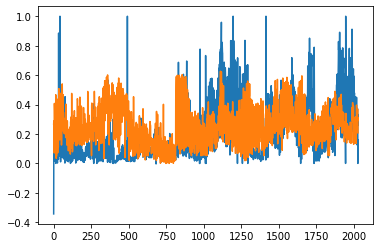

In [50]:
predict = model.predict(X_test)
plt.plot(Y_test)
plt.plot(predict)
plt.show()

In [51]:
# X_test = mobility_dict[regions_list_BR[22]][-460:,:]
# Y_test = cases_dict[regions_list_BR[22]][-460:]
# Y_test = Y_test.reshape((len(Y_test),1))
# print("Teste ",regions_list_BR[22])
# predict = model.predict(X_test)
# plt.plot(Y_test)
# plt.plot(predict)
# plt.show()

In [52]:
# X_test = mobility_dict[regions_list_BR[23]][-460:,:]
# Y_test = cases_dict[regions_list_BR[23]][-460:]
# Y_test = Y_test.reshape((len(Y_test),1))
# print("Teste ",regions_list_BR[23])
# predict = model.predict(X_test)
# plt.plot(Y_test)
# plt.plot(predict)
# plt.show()

In [53]:
# X_test = mobility_dict[regions_list_BR[24]][-460:,:]
# Y_test = cases_dict[regions_list_BR[24]][-460:]
# Y_test = Y_test.reshape((len(Y_test),1))
# print("Teste ",regions_list_BR[24])
# predict = model.predict(X_test)
# plt.plot(Y_test)
# plt.plot(predict)
# plt.show()

In [54]:
# X_test = mobility_dict[regions_list_BR[25]][-460:,:]
# Y_test = cases_dict[regions_list_BR[25]][-460:]
# Y_test = Y_test.reshape((len(Y_test),1))
# print("Teste ",regions_list_BR[25])
# predict = model.predict(X_test)
# plt.plot(Y_test)
# plt.plot(predict)
# plt.show()

In [55]:
# X_test = mobility_dict[regions_list_BR[26]][-460:,:]
# Y_test = cases_dict[regions_list_BR[26]][-460:]
# Y_test = Y_test.reshape((len(Y_test),1))
# print("Teste ",regions_list_BR[26])
# predict = model.predict(X_test)
# plt.plot(Y_test)
# plt.plot(predict)
# plt.show()

In [56]:


def getSelectedCities(df,cities_list):
    regions_dict = {}
    
#     print(regions_list)
    for r in cities_list:
        sub_df = df[(df['city']== r)]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r[:-3]]=sub_df
#     print(regions_dict)
    return regions_dict


cities_cols = ['epi_week','date','country','state',
               'city','ibgeID','newDeaths','deaths','newCases',
               'totalCases','deaths_per_100k_inhabitants',
               'totalCases_per_100k_inhabitants','deaths_by_totalCases','_source','last_info_date'
               ]

# cities_selected=['São Paulo/SP','Rio de Janeiro/RJ','Belo Horizonte/MG','Vitória/ES','Porto Alegre/RS','Curitiba/PR',
#                  'Campinas/SP', 'Florianópolis/SC','Salvador/BA','Fortaleza/CE','Manaus/AM','Recife/PE',
#                  'Goiânia/GO','Belém/PA','Guarulhos/SP','São Luís/MA','São Gonçalo/RJ','Maceió/AL',
#                  'Duque de Caxias/RJ','Campo Grande/MS','Natal/RN']
cities_selected=['São Paulo/SP','Campinas/SP','Guarulhos/SP','São Bernardo do Campo/SP',
                 'Santo André/SP','Ribeirão Preto/SP','Osasco/SP','Sorocaba/SP','Mauá/SP','São José do Rio Preto/SP',
                 'Mogi das Cruzes/SP','Santos/SP','Diadema/SP','Jundiaí/SP', 'Piracicaba/SP','Carapicuíba/SP',
                 'Bauru/SP','Itaquaquecetuba/SP','São Vicente/SP','Franca/SP','Marília/SP']
mob_cities_selected=[i[:-3] for i in cities_selected]
# print(mob_cities_selected)

cities_df = pd.read_csv('cases-brazil-cities-time_changesOnly.csv')
cities_covid = getSelectedCities(cities_df,cities_selected)
mob_cities = getCityGroups(mob_cities_selected)
# print(mob_cities)

In [57]:
def getCitiesData(mob_df,cases_df,cities_list):
    mobility_all = []
    cases_all = []
    mobility_dates = []
    cases_dates = []
    mobility_dict = {}
    cases_dict = {}
    
    for r in cities_list:
        newCases = cases_df[r]['newCases'].values
        newCases_norm = newCases/np.max(newCases)
        scaler = MinMaxScaler(feature_range=(-1,1))        
        mobility_norm = scaler.fit_transform(mob_df[r][categories_google_mobility].values)
        
        covid_dates = cases_df[r]['date'].values
        
        mob_dates = mob_df[r]['date'].values
        mob_dates += np.timedelta64(7,'D') # com offset de 7 dias
        
        mobility_dict[r] = mobility_norm
        cases_dict[r] = newCases_norm
        
        for i in range(len(newCases_norm)):
#             if covid_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            cases_all.append(newCases_norm[i]) 
            cases_dates.append(covid_dates[i])
            
        for i in range(len(mobility_norm)):
#             if mob_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            mobility_all.append(mobility_norm[i])
            mobility_dates.append(mob_dates[i])

    Y_data = (np.array([cases_all]).T)
    X_data = np.array(mobility_all)    
    
    
    return X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict


Xc_data, Yc_data, mobility_ct_dates, cases_ct_dates, mobility_ct_dict, cases_ct_dict = getCitiesData(mob_cities,cities_covid,mob_cities_selected)

print(Xc_data.shape)
print(Yc_data.shape)

(10857, 6)
(9317, 1)


In [58]:
Xc_filter, Yc_filter = getCorrespondentData(Xc_data,Yc_data, mobility_ct_dates,cases_ct_dates)
print(Xc_filter.shape)
print(Yc_filter.shape)

Xc_train = Xc_filter[:5900]
Yc_train = Yc_filter[:5900]
Xc_test = Xc_filter[5900:]
Yc_test = Yc_filter[5900:]
# X = mobility_norm[-460:,:]
# Y = newCases_norm[-470:-10]
# Y = Y.reshape((len(Y),1))

print("Mobility Features")
print(Xc_train[:5])
print("X shape: ",Xc_train.shape)


print("Covid Cases")
print(Yc_train[:5])
print("Y shape: ",Yc_train.shape)

(8747, 6)
(8747, 1)
Mobility Features
[[ 0.66990291  0.171875    0.19298246  0.85106383  0.89795918 -0.94444444]
 [ 0.70873786  0.375       0.28070175  0.89361702  0.91836735 -0.94444444]
 [ 0.24271845  0.09375    -0.47368421  0.21276596  0.30612245 -0.44444444]
 [ 0.57281553  0.34375     0.          0.72340426  0.81632653 -0.77777778]
 [ 0.82524272  0.40625     0.43859649  0.74468085  0.73469388 -0.72222222]]
X shape:  (5900, 6)
Covid Cases
[[0.00011566]
 [0.00011566]
 [0.00011566]
 [0.00034698]
 [0.00069396]]
Y shape:  (5900, 1)


In [59]:

city_model = Sequential()
city_model.add(Dense(6, input_dim=6, activation='relu'))
city_model.add(Dense(12, activation='relu'))
# city_model.add(Dense(12, activation='relu'))
city_model.add(Dense(6, activation='relu'))
city_model.add(Dense(1, activation='relu'))
city_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

city_model.fit(X_train, Y_train, epochs=700, batch_size=180)



Epoch 1/700
50/50 [==============================] - 1s 651us/step - loss: 0.6490 - accuracy: 0.0101
Epoch 2/700
50/50 [==============================] - 0s 672us/step - loss: 0.5763 - accuracy: 0.0116
Epoch 3/700
50/50 [==============================] - 0s 794us/step - loss: 0.5580 - accuracy: 0.0113
Epoch 4/700
50/50 [==============================] - 0s 733us/step - loss: 0.5496 - accuracy: 0.0116
Epoch 5/700
50/50 [==============================] - 0s 733us/step - loss: 0.5510 - accuracy: 0.0100
Epoch 6/700
50/50 [==============================] - 0s 621us/step - loss: 0.5508 - accuracy: 0.0108
Epoch 7/700
50/50 [==============================] - 0s 651us/step - loss: 0.5529 - accuracy: 0.0094
Epoch 8/700
50/50 [==============================] - 0s 631us/step - loss: 0.5488 - accuracy: 0.0126
Epoch 9/700
50/50 [==============================] - 0s 611us/step - loss: 0.5482 - accuracy: 0.0103
Epoch 10/700
50/50 [==============================] - 0s 631us/step - loss: 0.5462 - accura

50/50 [==============================] - 0s 570us/step - loss: 0.5296 - accuracy: 0.0091
Epoch 82/700
50/50 [==============================] - 0s 651us/step - loss: 0.5350 - accuracy: 0.0120
Epoch 83/700
50/50 [==============================] - 0s 631us/step - loss: 0.5309 - accuracy: 0.0109
Epoch 84/700
50/50 [==============================] - 0s 590us/step - loss: 0.5341 - accuracy: 0.0093
Epoch 85/700
50/50 [==============================] - 0s 611us/step - loss: 0.5352 - accuracy: 0.0110
Epoch 86/700
50/50 [==============================] - 0s 590us/step - loss: 0.5349 - accuracy: 0.0122
Epoch 87/700
50/50 [==============================] - 0s 590us/step - loss: 0.5308 - accuracy: 0.0099
Epoch 88/700
50/50 [==============================] - 0s 590us/step - loss: 0.5351 - accuracy: 0.0092
Epoch 89/700
50/50 [==============================] - 0s 560us/step - loss: 0.5320 - accuracy: 0.0111
Epoch 90/700
50/50 [==============================] - 0s 773us/step - loss: 0.5304 - accuracy: 

50/50 [==============================] - 0s 631us/step - loss: 0.5330 - accuracy: 0.0112
Epoch 161/700
50/50 [==============================] - 0s 601us/step - loss: 0.5309 - accuracy: 0.0105
Epoch 162/700
50/50 [==============================] - 0s 590us/step - loss: 0.5272 - accuracy: 0.0096
Epoch 163/700
50/50 [==============================] - 0s 631us/step - loss: 0.5311 - accuracy: 0.0110
Epoch 164/700
50/50 [==============================] - 0s 631us/step - loss: 0.5314 - accuracy: 0.0121
Epoch 165/700
50/50 [==============================] - 0s 651us/step - loss: 0.5279 - accuracy: 0.0114
Epoch 166/700
50/50 [==============================] - 0s 631us/step - loss: 0.5304 - accuracy: 0.0111
Epoch 167/700
50/50 [==============================] - 0s 590us/step - loss: 0.5330 - accuracy: 0.0117
Epoch 168/700
50/50 [==============================] - 0s 631us/step - loss: 0.5397 - accuracy: 0.0109
Epoch 169/700
50/50 [==============================] - 0s 631us/step - loss: 0.5315 - a

50/50 [==============================] - 0s 611us/step - loss: 0.5261 - accuracy: 0.0117
Epoch 240/700
50/50 [==============================] - 0s 672us/step - loss: 0.5301 - accuracy: 0.0094
Epoch 241/700
50/50 [==============================] - 0s 631us/step - loss: 0.5324 - accuracy: 0.0105
Epoch 242/700
50/50 [==============================] - 0s 672us/step - loss: 0.5296 - accuracy: 0.0113
Epoch 243/700
50/50 [==============================] - 0s 611us/step - loss: 0.5316 - accuracy: 0.0111
Epoch 244/700
50/50 [==============================] - 0s 672us/step - loss: 0.5312 - accuracy: 0.0109
Epoch 245/700
50/50 [==============================] - 0s 590us/step - loss: 0.5319 - accuracy: 0.0100
Epoch 246/700
50/50 [==============================] - 0s 631us/step - loss: 0.5319 - accuracy: 0.0102
Epoch 247/700
50/50 [==============================] - 0s 611us/step - loss: 0.5306 - accuracy: 0.0109
Epoch 248/700
50/50 [==============================] - 0s 936us/step - loss: 0.5295 - a

50/50 [==============================] - 0s 611us/step - loss: 0.5261 - accuracy: 0.0120
Epoch 319/700
50/50 [==============================] - 0s 611us/step - loss: 0.5250 - accuracy: 0.0120
Epoch 320/700
50/50 [==============================] - 0s 672us/step - loss: 0.5273 - accuracy: 0.0120
Epoch 321/700
50/50 [==============================] - 0s 611us/step - loss: 0.5326 - accuracy: 0.0101
Epoch 322/700
50/50 [==============================] - 0s 651us/step - loss: 0.5325 - accuracy: 0.0094
Epoch 323/700
50/50 [==============================] - 0s 590us/step - loss: 0.5250 - accuracy: 0.0098
Epoch 324/700
50/50 [==============================] - 0s 611us/step - loss: 0.5275 - accuracy: 0.0106
Epoch 325/700
50/50 [==============================] - 0s 570us/step - loss: 0.5288 - accuracy: 0.0093
Epoch 326/700
50/50 [==============================] - 0s 631us/step - loss: 0.5301 - accuracy: 0.0102
Epoch 327/700
50/50 [==============================] - 0s 611us/step - loss: 0.5289 - a

50/50 [==============================] - 0s 733us/step - loss: 0.5313 - accuracy: 0.0105
Epoch 398/700
50/50 [==============================] - 0s 651us/step - loss: 0.5318 - accuracy: 0.0096
Epoch 399/700
50/50 [==============================] - 0s 672us/step - loss: 0.5355 - accuracy: 0.0086
Epoch 400/700
50/50 [==============================] - 0s 733us/step - loss: 0.5303 - accuracy: 0.0120
Epoch 401/700
50/50 [==============================] - 0s 651us/step - loss: 0.5330 - accuracy: 0.0105
Epoch 402/700
50/50 [==============================] - 0s 692us/step - loss: 0.5325 - accuracy: 0.0104
Epoch 403/700
50/50 [==============================] - 0s 651us/step - loss: 0.5340 - accuracy: 0.0115
Epoch 404/700
50/50 [==============================] - 0s 712us/step - loss: 0.5337 - accuracy: 0.0109
Epoch 405/700
50/50 [==============================] - 0s 773us/step - loss: 0.5302 - accuracy: 0.0121
Epoch 406/700
50/50 [==============================] - 0s 672us/step - loss: 0.5338 - a

50/50 [==============================] - 0s 712us/step - loss: 0.5247 - accuracy: 0.0105
Epoch 477/700
50/50 [==============================] - 0s 662us/step - loss: 0.5262 - accuracy: 0.0117
Epoch 478/700
50/50 [==============================] - 0s 794us/step - loss: 0.5309 - accuracy: 0.0103
Epoch 479/700
50/50 [==============================] - 0s 672us/step - loss: 0.5264 - accuracy: 0.0116
Epoch 480/700
50/50 [==============================] - 0s 702us/step - loss: 0.5299 - accuracy: 0.0108
Epoch 481/700
50/50 [==============================] - 0s 957us/step - loss: 0.5285 - accuracy: 0.0122
Epoch 482/700
50/50 [==============================] - 0s 712us/step - loss: 0.5252 - accuracy: 0.0132
Epoch 483/700
50/50 [==============================] - 0s 672us/step - loss: 0.5332 - accuracy: 0.0104
Epoch 484/700
50/50 [==============================] - 0s 611us/step - loss: 0.5312 - accuracy: 0.0084
Epoch 485/700
50/50 [==============================] - 0s 753us/step - loss: 0.5280 - a

50/50 [==============================] - 0s 672us/step - loss: 0.5292 - accuracy: 0.0107
Epoch 556/700
50/50 [==============================] - 0s 834us/step - loss: 0.5264 - accuracy: 0.0100
Epoch 557/700
50/50 [==============================] - 0s 631us/step - loss: 0.5290 - accuracy: 0.0100
Epoch 558/700
50/50 [==============================] - 0s 733us/step - loss: 0.5274 - accuracy: 0.0100
Epoch 559/700
50/50 [==============================] - 0s 835us/step - loss: 0.5281 - accuracy: 0.0106
Epoch 560/700
50/50 [==============================] - 0s 835us/step - loss: 0.5251 - accuracy: 0.0108
Epoch 561/700
50/50 [==============================] - 0s 753us/step - loss: 0.5275 - accuracy: 0.0092
Epoch 562/700
50/50 [==============================] - 0s 1ms/step - loss: 0.5253 - accuracy: 0.0118
Epoch 563/700
50/50 [==============================] - 0s 712us/step - loss: 0.5293 - accuracy: 0.0112
Epoch 564/700
50/50 [==============================] - 0s 692us/step - loss: 0.5312 - acc

50/50 [==============================] - 0s 753us/step - loss: 0.5252 - accuracy: 0.0125
Epoch 635/700
50/50 [==============================] - 0s 672us/step - loss: 0.5265 - accuracy: 0.0116
Epoch 636/700
50/50 [==============================] - 0s 651us/step - loss: 0.5263 - accuracy: 0.0108
Epoch 637/700
50/50 [==============================] - 0s 672us/step - loss: 0.5249 - accuracy: 0.0107
Epoch 638/700
50/50 [==============================] - 0s 651us/step - loss: 0.5262 - accuracy: 0.0107
Epoch 639/700
50/50 [==============================] - 0s 733us/step - loss: 0.5313 - accuracy: 0.0110
Epoch 640/700
50/50 [==============================] - 0s 621us/step - loss: 0.5249 - accuracy: 0.0124
Epoch 641/700
50/50 [==============================] - 0s 692us/step - loss: 0.5306 - accuracy: 0.0106
Epoch 642/700
50/50 [==============================] - 0s 590us/step - loss: 0.5271 - accuracy: 0.0113
Epoch 643/700
50/50 [==============================] - 0s 682us/step - loss: 0.5254 - a

In [60]:
# evaluate the keras model
_, accuracy = city_model.evaluate(Xc_train, Yc_train)
print('Accuracy: %.2f' % (accuracy*100))

185/185 [==============================] - 0s 493us/step - loss: 0.5341 - accuracy: 0.0012
Accuracy: 0.12


In [61]:
_, accuracY_test = city_model.evaluate(Xc_test, Yc_test)
print('AccuracY_test: %.2f' % (accuracY_test*100))

89/89 [==============================] - 0s 533us/step - loss: 0.4979 - accuracy: 0.0014
AccuracY_test: 0.14


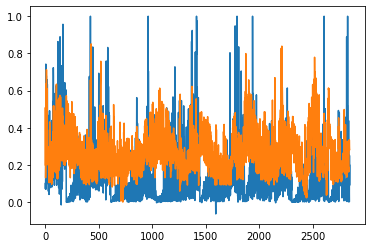

In [62]:
predict = city_model.predict(Xc_test)
plt.plot(Yc_test)
plt.plot(predict)
plt.show()

Teste  Bauru


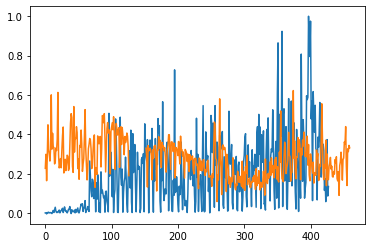

In [63]:
Xc_test = mobility_ct_dict['Bauru'][-460:,:]
Yc_test = cases_ct_dict['Bauru'][-460:]
Yc_test = Yc_test.reshape((len(Yc_test),1))
print("Teste ",'Bauru')
predict = city_model.predict(Xc_test)
plt.plot(Yc_test)
plt.plot(predict)
plt.show()


In [64]:
# import gzip
# import urllib.request
# import io

# # response = urllib.request.urlopen('https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time_changesOnly.csv.gz')
# # compressed_file = io.BytesIO(response.read())

# # print(decompressed_file)



# import requests

# url = 'https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time_changesOnly.csv.gz'
# filename = url.split("/")[-1]
# with open(filename, "wb") as f:
#     r = requests.get(url)
#     f.write(r.content)
    
# gz_file = open(filename, "r")
# decompressed_file = gzip.GzipFile(fileobj=gz_file)
# print(decompressed_file)
# data = pd.read_csv(decompressed_file)
# print(data)